In [1]:
!pip install git+https://github.com/openai/whisper.git
!pip install transformers

  Cloning https://github.com/openai/whisper.git to c:\users\sumanyu.p\appdata\local\temp\pip-req-build-8k2e2zz5
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git 'C:\Users\sumanyu.p\AppData\Local\Temp\pip-req-build-8k2e2zz5'


In [3]:
!pip install --ignore-installed --upgrade tensorflow 

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached setuptools-70.1.1-py3-none-any.whl.metadata (6.0 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached wrapt-1.16.0-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------------------------- ------------ 41.0/61.0 kB 960.0 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.0 kB 960.0 kB/s eta 0:00:01
     --------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\sumanyu.p\\AppData\\Local\\anaconda3\\Lib\\site-packages\\wrapt\\_wrappers.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



   -------------------------------- ------- 305.7/377.0 MB 4.0 MB/s eta 0:00:18
   -------------------------------- ------- 306.1/377.0 MB 4.0 MB/s eta 0:00:18
   -------------------------------- ------- 306.6/377.0 MB 4.1 MB/s eta 0:00:18
   -------------------------------- ------- 307.0/377.0 MB 4.0 MB/s eta 0:00:18
   -------------------------------- ------- 307.4/377.0 MB 4.0 MB/s eta 0:00:18
   -------------------------------- ------- 307.5/377.0 MB 4.0 MB/s eta 0:00:18
   -------------------------------- ------- 307.6/377.0 MB 3.9 MB/s eta 0:00:18
   -------------------------------- ------- 307.8/377.0 MB 4.0 MB/s eta 0:00:18
   -------------------------------- ------- 307.9/377.0 MB 4.0 MB/s eta 0:00:18
   -------------------------------- ------- 308.0/377.0 MB 4.0 MB/s eta 0:00:18
   -------------------------------- ------- 308.2/377.0 MB 3.9 MB/s eta 0:00:18
   -------------------------------- ------- 308.2/377.0 MB 3.9 MB/s eta 0:00:18
   -------------------------------- ----

In [1]:
import whisper
import json
import os
import tensorflow as tf
from tqdm.notebook import tqdm
import torch
import torchaudio
import torchaudio.transforms as T
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from time import perf_counter
import pandas as pd
import numpy as np
import IPython
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [8]:
import os

directory = "./recordings"
wav_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(".wav")]
print(f"Number of wav files: {len(wav_files)}")

Number of wav files: 10


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# Your existing code to load the model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
import os
import torch
import torchaudio
from tqdm import tqdm


def get_embeddings(file_path):
    with torch.no_grad():
        clip, sample_rate = torchaudio.load(file_path)
        x = model(clip.to(device))
    return torch.mean(x.extract_features, dim=1)[0].cpu().numpy()

# Directory containing .wav files
directory = "./recordings"
wav_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(".wav")]

# Creating speech representation for audio samples
embeddings = []
for file in tqdm(wav_files):
    embeddings.append(get_embeddings(file))



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


In [25]:
embeddings=np.array(embeddings)
embeddings.shape
embeddings

array([[ 0.05534939,  0.05403031, -0.0976252 , ..., -0.2266273 ,
         0.16231154,  0.283258  ],
       [ 0.07084432,  0.05575978, -0.06413458, ..., -0.23995478,
         0.17308085,  0.32097417],
       [ 0.06497779,  0.0433313 , -0.07208992, ..., -0.21673828,
         0.20216559,  0.34175745],
       ...,
       [ 0.05110368,  0.08580659, -0.11000457, ..., -0.18377848,
         0.13738391,  0.29719397],
       [ 0.05125032,  0.03551582, -0.08236254, ..., -0.06021739,
         0.17078306,  0.33427784],
       [ 0.08181132,  0.05891073, -0.10113934, ..., -0.19586669,
         0.14818431,  0.32172063]], dtype=float32)

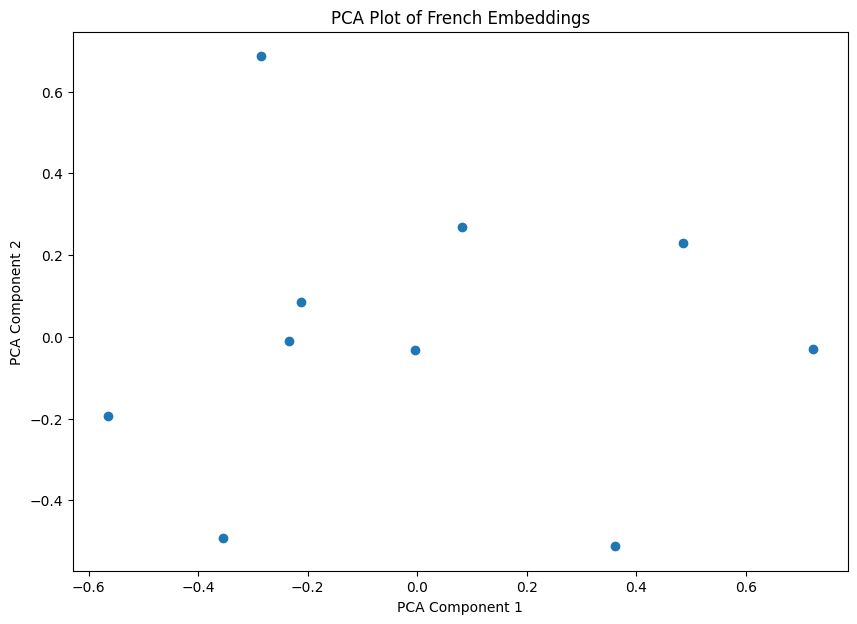

In [24]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming embeddings is already defined (for one language, e.g., French)
# embeddings = np.array(embeddings)  # Assuming embeddings is already a numpy array

# Perform PCA
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10,7))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1])
plt.title("PCA Plot of French Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4, random_state=10)
kmeans.fit(embeddings)

KMeans(n_clusters=4, random_state=10)

In [28]:
def predict(clip):
  with torch.no_grad():
   x = model(clip.cuda())
   x = torch.mean(x.extract_features, dim = 1)[0].cpu().numpy()
   return kmeans.predict(x.reshape(1,-1))

In [31]:
# times = []
# labels = []

# # Loop over each .wav file
# for file in tqdm(wav_files):
#     # Load the audio clip
#     clip, sample_rate = torchaudio.load(file)
    
#     # Assuming you need to move clip to GPU if your model is on GPU
#     clip = clip.cuda()

#     # Record the start time
#     start = perf_counter()
    
#     # Make predictions
#     prediction = predict(clip)
    
#     # Record the elapsed time
#     times.append(perf_counter() - start)
    
#     # Optionally, if you have labels or other processing to do, do it here
#     # labels.append(label)

# # Example of printing the times
# print("Prediction times:")
# for i, time in enumerate(times):
#     print(f"File {i+1}: {time:.4f} seconds")

In [30]:
! pip install git+https://github.com/openai/whisper.git -q

In [32]:
import whisper

small_model = whisper.load_model("small")
medium_model = whisper.load_model("medium")
large_model = whisper.load_model("large")

100%|█████████████████████████████████████| 1.42G/1.42G [05:18<00:00, 4.79MiB/s]
100%|█████████████████████████████████████| 2.88G/2.88G [13:10<00:00, 3.90MiB/s]


In [ ]:
import requests

url = "http://www.moviesoundclips.net/movies1/darkknightrises/darkness.mp3"
file_name = "audio.mp3"

response = requests.get(url)
if response.status_code == 200:
    with open(file_name, 'wb') as f:
        f.write(response.content)
    print(f"File '{file_name}' downloaded successfully.")
else:
    print(f"Failed to download '{file_name}'")

In [ ]:
from IPython.display import Audio
Audio("audio.mp3")